In [14]:
#***********************************************************************************************
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from music21 import *
from tensorflow.keras.utils import to_categorical
import random

**Example of music21**

In [15]:
from music21 import stream, harmony, duration
# Create a stream to hold the chords
chord_stream = stream.Stream()

# Define the chord progression and durations
chord_names = ['C', 'F', 'G', 'C']
chord_durations = [1, 1, 1, 1]  # Whole notes

# Create and add chords to the stream
for chord_name, dur in zip(chord_names, chord_durations):
    chord = harmony.ChordSymbol(chord_name)
    chord.duration = duration.Duration(dur)
    chord_stream.append(chord)

# Show the stream
chord_stream.show('text')  # This will display the stream in a text-based format

# To create a MIDI file:
chord_stream.write('midi', fp='chord_progression.mid')

{0.0} <music21.harmony.ChordSymbol C>
{1.0} <music21.harmony.ChordSymbol F>
{2.0} <music21.harmony.ChordSymbol G>
{3.0} <music21.harmony.ChordSymbol C>


'chord_progression.mid'

**Agent Definition**

In [54]:
class MusicComposerAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size  # Length of the chord sequence representing the state
        self.action_size = action_size  # Number of possible actions (chords)
        self.memory = []  # Memory for storing experiences
        self.gamma = 0.95  # Discount rate for future rewards
        self.epsilon = 0.3  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.lstm_model = self._build_lstm_model()

    def _build_lstm_model(self):
        """Builds an LSTM network to be used by the agent."""
        model = Sequential()
        model.add(LSTM(50, input_shape=(self.state_size, self.action_size), return_sequences=True))
        model.add(LSTM(50))
        model.add(Dense(self.action_size, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam')
        return model

    def choose_action(self, state):
        """Chooses the next action (chord) based on the current state."""
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)  # Explore: choose a random action
        action_probs = self.lstm_model.predict(state);  # Exploit: choose best action based on model
        return np.argmax(action_probs[0])

    def remember(self, state, action, reward, next_state, done):
        """Stores an experience in memory."""
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        """Trains the agent using a batch of past experiences."""
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            # Reshape the states to match the input shape expected by the LSTM model
            state_reshaped = np.reshape(state, (1, self.state_size, self.action_size))
            next_state_reshaped = np.reshape(next_state, (1, self.state_size, self.action_size))

            target = reward
            if not done:
                # Predict for the reshaped next state
                target = (reward + self.gamma * np.amax(self.lstm_model.predict(next_state_reshaped)[0]));
            target_f = self.lstm_model.predict(state_reshaped);
            target_f[0][action] = target
            self.lstm_model.fit(state_reshaped, target_f, epochs=1, verbose=0);

    def calculate_reward(self, state, action):
        musical_key = ['C', 'Dm', 'Em', 'F', 'G', 'Am', 'Bdim'] #  'Cmaj7', 'Dm7', 'G7'
        chord_history_length = 16  # Number of previous chords to consider for context
        reward = 0

        # Extract the current and previous chords
        current_chord_index = action % len(musical_key) # Determine the index of the current chord based on the agent's action.
        current_chord = musical_key[current_chord_index] # Retrieve the current chord from the musical key using the index.
        # Create a list of previously selected chords based on the current state.
        previous_chords = [
            musical_key[np.argmax(state[i])]  # finds the index of the highest value in each segment, which corresponds to the selected chord in that part of the state.
            for i in range(len(state) - chord_history_length, len(state))
        ]

        # Reward for common chord progressions
        common_progressions = [
            (['F', 'G'], 'C'),      # IV-V-I progression
            (['Dm', 'G'], 'C'),     # ii-V-I progression
            (['Am', 'Dm', 'G'], 'C'),  # vi-ii-V-I progression
            (['C', 'Am', 'Dm', 'G'], 'C'),  # I-vi-ii-V progression
            (['Am', 'F', 'C', 'G'], 'Am'),  # vi-IV-I-V progression
            (['C', 'G', 'Am', 'F'], 'C'),   # I-V-vi-IV progression
            # Add other common progressions here
        ]
        for progression, next_chord in common_progressions:
            if previous_chords[-len(progression):] == progression and current_chord == next_chord:
                reward += 1.0  # Increase the reward for common progressions

        # Penalty for excessive repetition
        repetition_penalty = 2.0  # Increased penalty for repetition
        if previous_chords.count(current_chord) > 2:  # Penalize if the same chord is repeated more than 2 times in a row
            reward -= repetition_penalty

        # Reward for chord variety
        unique_chords = len(set(previous_chords))
        reward += unique_chords * 0.1  # Reward based on the number of unique chords in the recent history

        # Immediate transition reward
        transition_matrix = [
            [0.15, 0.1, 0.15, 0.2, 0.15, 0.1, 0],  #C
            [0.15, 0.05, 0.1, 0.15, 0.18, 0.15, 0],  #Dm
            [0.15, 0.1, 0.1, 0.18, 0.15, 0.15, 0.1],  #Em
            [0.18, 0.1, 0.15, 0.15, 0.15, 0.15, 0.1],  #F
            [0.18, 0.1, 0.1, 0.15, 0.15, 0.1, 0.1],  #G
            [0.15, 0.15, 0.1, 0.15, 0.1, 0.1, 0],  #Am
            [0.15, 0, 0.1, 0.1, 0.1, 0.05, 0]   #Bdim
        ]
        last_chord_index = np.argmax(state[0][-len(musical_key):])
        immediate_transition_reward = transition_matrix[last_chord_index][current_chord_index]
        reward += immediate_transition_reward

        # Check for repeating patterns in the last 4 bars
        if len(state) >= chord_history_length:
            last_four_bars = [musical_key[np.argmax(state[i])] for i in range(-chord_history_length, 0)]
            if self.is_repeating_pattern(last_four_bars, 4):
                print(last_four_bars)
                reward += 2.0  # Major reward for a repeating pattern over 4 bars
            elif self.is_repeating_pattern(last_four_bars, 2):
                print(last_four_bars)
                reward += 1.0  # Major reward for a repeating pattern over 2 bars
        # Check if the last chord in the song is the same as the first chord
        if len(state) == self.state_size:
            first_chord_index = np.argmax(state[0])
            last_chord_index = np.argmax(state[-1])
            if first_chord_index == last_chord_index:
                reward += 1.0

        return reward

    def is_repeating_pattern(self, sequence, bar_length):
        """Checks if there is a repeating pattern over the specified bar length."""
        # If the agent has not played enough notes, there is no repeating pattern, return false
        if len(sequence) < bar_length * 2:
            return False
        num_bars = len(sequence) // bar_length
        for i in range(num_bars - 1):
            if sequence[i * bar_length:(i + 1) * bar_length] != sequence[(i + 1) * bar_length:(i + 2) * bar_length]:
                return False
        return True
    
    def train(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = np.random.choice(self.memory, batch_size, replace=False)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.lstm_model.predict(next_state)[0]));
            target_f = self.lstm_model.predict(state);
            target_f[0][action] = target
            self.lstm_model.fit(state, target_f, epochs=1, verbose=0);
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

**Implementation**

In [22]:
from music21 import harmony, duration

def action_to_chord_duration(action_index):
    # Define chords and durations
    chords = ['C', 'Dm', 'Em', 'F', 'G', 'Am', 'Bdim'] # 'Cmaj7', 'Dm7', 'G7'
    durations = [1]  # can use [0.25, 0.5, 1, 2] Representing quarter, half, whole, and double whole notes

    num_chords = len(chords)
    num_durations = len(durations)

    # Calculate the chord index and duration index
    chord_index = action_index % num_chords
    duration_index = action_index // num_chords

    chord_name = chords[chord_index]
    dur = durations[duration_index]

    # Create a chord symbol and set its duration
    chord = harmony.ChordSymbol(chord_name)
    chord.duration = duration.Duration(dur)

    return chord, dur

# Example usage
action_index = 5  # Suppose the agent chose action index 5
chord, dur = action_to_chord_duration(action_index)
print(f"Chord: {chord}, Duration: {dur}")


Chord: <music21.harmony.ChordSymbol Am>, Duration: 1


**Dataset**

In [23]:
import numpy as np
import random

# Chord mapping to indices
chords = ['C', 'Dm', 'Em', 'F', 'G', 'Am', 'Bdim']
chord_to_index = {chord: i for i, chord in enumerate(chords)}

# Predefined chord progressions (patterns)
progressions = [
    [chord_to_index[chord] for chord in ['C', 'G', 'Am', 'F']], # I-V-vi-IV
    [chord_to_index[chord] for chord in ['Am', 'F', 'C', 'G']], # vi-IV-I-V
    [chord_to_index[chord] for chord in ['F', 'G', 'Em', 'Am']], # IV-V-iii-vi
]

# Generate sequences with patterns and randomness
num_sequences = 100
sequence_length = 64
dataset = []

for _ in range(num_sequences):
    sequence = []
    while len(sequence) < sequence_length:
        if random.random() < 0.3:  # 30% chance to add a progression
            progression = random.choice(progressions)
            sequence.extend(progression[:sequence_length - len(sequence)])
        elif len(sequence) >= 4 and random.random() < 0.15:  # 15% chance to repeat last 4 chords
            sequence.extend(sequence[-4:])
        else:
            next_chord = np.random.randint(len(chords))
            sequence.append(next_chord)
    dataset.append(sequence[:sequence_length])  # Ensure sequence length

# Convert to a format suitable for training
dataset = np.array(dataset)

# Print the first sequence as an example
print("Example sequence (indices):", dataset[0])
print("Example sequence (chords):", [chords[i] for i in dataset[0]])


Example sequence (indices): [5 3 0 4 6 5 3 0 4 0 4 5 3 4 2 1 2 3 4 2 5 3 4 2 5 4 6 2 5 4 6 3 4 2 5 2 3
 3 4 2 5 3 4 2 5 3 5 3 0 4 3 4 2 5 1 3 3 4 2 5 5 3 0 4]
Example sequence (chords): ['Am', 'F', 'C', 'G', 'Bdim', 'Am', 'F', 'C', 'G', 'C', 'G', 'Am', 'F', 'G', 'Em', 'Dm', 'Em', 'F', 'G', 'Em', 'Am', 'F', 'G', 'Em', 'Am', 'G', 'Bdim', 'Em', 'Am', 'G', 'Bdim', 'F', 'G', 'Em', 'Am', 'Em', 'F', 'F', 'G', 'Em', 'Am', 'F', 'G', 'Em', 'Am', 'F', 'Am', 'F', 'C', 'G', 'F', 'G', 'Em', 'Am', 'Dm', 'F', 'F', 'G', 'Em', 'Am', 'Am', 'F', 'C', 'G']


In [26]:
%%capture
# Parameters for the agent
state_size = 16 # Number of previous chords to use as the state
action_size = 7

# Convert sequences to a format suitable for training
def one_hot_encode(sequence, num_classes):
    return to_categorical(sequence, num_classes=num_classes)

encoded_dataset = [one_hot_encode(sequence, action_size) for sequence in dataset]


# Initialize the agent
agent = MusicComposerAgent(state_size, action_size)

# Data collection for analysis
epoch_rewards = []
epoch_losses = []
epsilon_values = []

# Training the agent
num_epochs = 10
batch_size = 32
for epoch in range(num_epochs):
    total_rewards = 0
    total_loss = 0
    num_steps = 0
    
    for sequence in encoded_dataset:
        for i in range(0, len(sequence) - state_size):
            state = sequence[i:i + state_size];
            next_state = sequence[i + 1:i + state_size + 1];
            action = np.argmax(sequence[i + state_size]);
            reward = agent.calculate_reward(state, action);
            done = (i + state_size + 1 == len(sequence));
            agent.remember(state, action, reward, next_state, done);
            
            total_rewards += reward
            num_steps += 1

        if len(agent.memory) > batch_size:
            loss = agent.replay(batch_size);
            if loss is not None:
                total_loss += loss

    average_reward = total_rewards / num_steps
    average_loss = total_loss / num_steps if num_steps > 0 else 0

    # Record data for analysis
    epoch_rewards.append(average_reward)
    epoch_losses.append(average_loss)
    epsilon_values.append(agent.epsilon)

    # Update epsilon
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
    
    print(f"Epoch {epoch + 1}/{num_epochs} completed. Avg Reward: {average_reward}, Avg Loss: {average_loss}, Epsilon: {agent.epsilon}")



In [27]:
# Function to generate a sequence of chords using the trained agent
def generate_chords(agent, initial_state, desired_length, state_size, action_size):
    generated_sequence = initial_state.copy()
    for _ in range(desired_length):
        if len(generated_sequence) < state_size:
            current_state = np.zeros((state_size, action_size))  # Padding with zeros
        else:
            current_state = one_hot_encode(generated_sequence[-state_size:], action_size)

        current_state_input = np.reshape(current_state, (1, state_size, action_size))
        next_action = agent.choose_action(current_state_input)
        generated_sequence.append(next_action)
    
    return generated_sequence

# Generate a new song
desired_length = 32  # Length of the song (number of chords)
initial_state = []   # Starting with an empty sequence
generated_chords = generate_chords(agent, initial_state, desired_length, state_size, action_size)

# Convert the generated sequence to music21 stream
generated_composition = stream.Stream()
for action_index in generated_chords:
    chord_symbol, chord_duration = action_to_chord_duration(action_index)
    generated_composition.append(chord_symbol)

# Show or play the generated composition
generated_composition.show('midi')
generated_composition.write('midi', fp='model_output_example.mid')

1/1 [==============================] - 0s 15ms/step


'model_output_6.mid'

#### Analysis

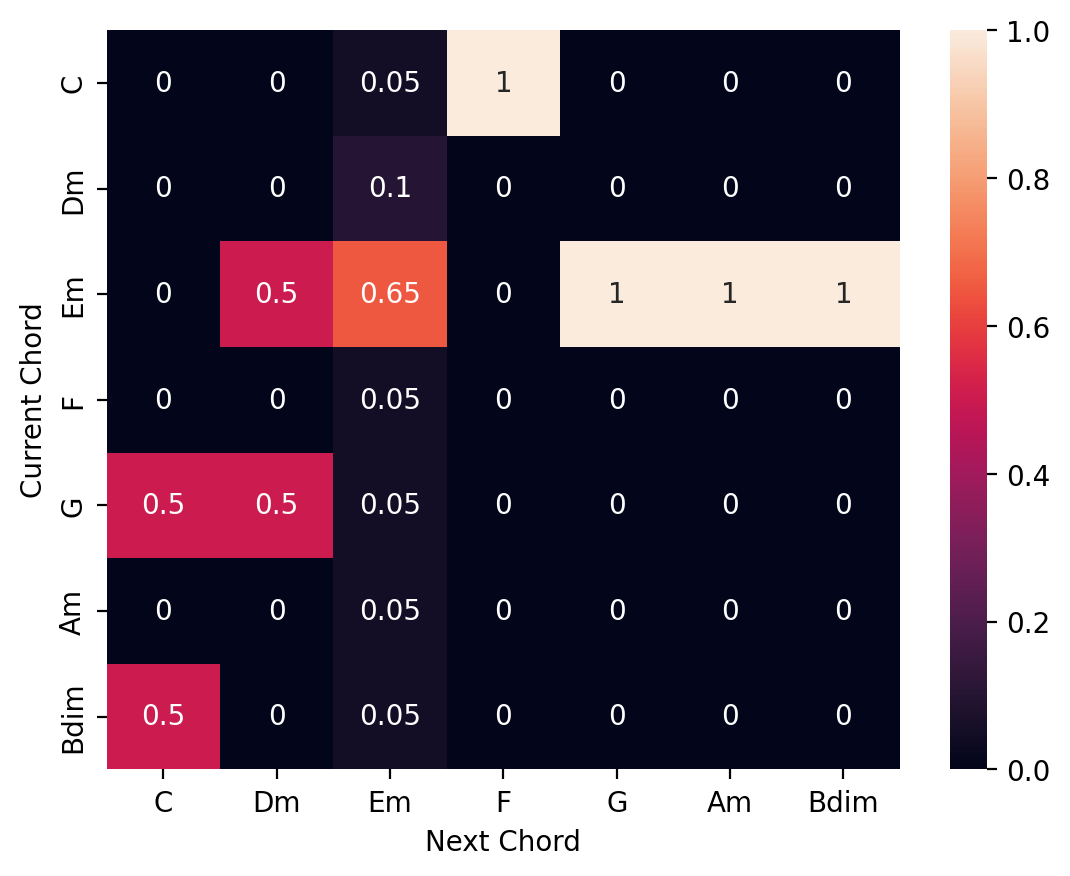

In [33]:
# Plot the transition matrix for the generated song
import seaborn as sns
transition_matrix = np.zeros((action_size, action_size))
for i in range(len(generated_chords) - 1):
    transition_matrix[generated_chords[i]][generated_chords[i + 1]] += 1
transition_matrix = transition_matrix / np.sum(transition_matrix, axis=1)
sns.heatmap(transition_matrix, annot=True, xticklabels=chords, yticklabels=chords)
plt.xlabel('Next Chord')
plt.ylabel('Current Chord')
plt.show()

In [59]:
# Make the model generate 100 songs
for i in range(100):
    desired_length = 32  # Length of the song (number of chords)
    initial_state = []
    generated_chords = generate_chords(agent, initial_state, desired_length, state_size, action_size)

    # Convert the generated sequence to music21 stream
    generated_composition = stream.Stream()
    for action_index in generated_chords:
        chord_symbol, chord_duration = action_to_chord_duration(action_index)
        generated_composition.append(chord_symbol)

    # Show or play the generated composition
    #generated_composition.show('midi')
    generated_composition.write('midi', fp=f'model_output_{i}.mid')

1/1 [==============================] - 0s 16ms/step


In [35]:
# Show the generated chords for each song
for i in range(10):
    print(f"Song {i + 1}")
    song = converter.parse(f'model_output_{i}.mid')
    song.show('text')
    print("\n")

Song 1
{0.0} <music21.metadata.Metadata object at 0x21ab304a650>
{0.0} <music21.stream.Part 0x21cc8fd3210>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.instrument.Instrument ''>
        {0.0} <music21.clef.BassClef>
        {0.0} <music21.tempo.MetronomeMark animato Quarter=120>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.chord.Chord C3 E3 G3>
        {1.0} <music21.chord.Chord E3 G3 B3>
        {2.0} <music21.chord.Chord G3 B3 D4>
        {3.0} <music21.chord.Chord E3 G3 B3>
    {4.0} <music21.stream.Measure 2 offset=4.0>
        {0.0} <music21.chord.Chord G3 B3 D4>
        {1.0} <music21.chord.Chord E3 G3 B3>
        {2.0} <music21.chord.Chord E3 G3 B3>
        {3.0} <music21.chord.Chord E3 G3 B3>
    {8.0} <music21.stream.Measure 3 offset=8.0>
        {0.0} <music21.chord.Chord E3 G3 B3>
        {1.0} <music21.chord.Chord E3 G3 B3>
        {2.0} <music21.chord.Chord E3 G3 B3>
        {3.0} <music21.chord.Chord G3 B3 D4>
    {12.0}

In [60]:
def evaluate_song(song, musical_key):
    transition_matrix = [
        [0.15, 0.1, 0.15, 0.2, 0.15, 0.1, 0],  # C
        [0.15, 0.05, 0.1, 0.15, 0.18, 0.15, 0],  # Dm
        [0.15, 0.1, 0.1, 0.18, 0.15, 0.15, 0.1],  # Em
        [0.18, 0.1, 0.15, 0.15, 0.15, 0.15, 0.1],  # F
        [0.18, 0.1, 0.1, 0.15, 0.15, 0.1, 0.1],  # G
        [0.15, 0.15, 0.1, 0.15, 0.1, 0.1, 0],  # Am
        [0.15, 0, 0.1, 0.1, 0.1, 0.05, 0]  # Bdim
    ]

    reward = 0
    previous_chord_index = None

    for i in range(len(song)):
        current_chord_index = musical_key.index(song[i])
        if previous_chord_index is not None:
            reward += transition_matrix[previous_chord_index][current_chord_index]
        previous_chord_index = current_chord_index

        # Check for repeating patterns in the last 4 chords
        if i >= 4 and song[i-4:i] == song[i-8:i-4]:
            reward += 1  # Reward for a repeating pattern over 4 chords

    # Check if the song resolves on the same chord it started with
    if song[0] == song[-1]:
        reward += 1

    return reward

# Function to convert MIDI file to a list of chords
def midi_to_chords(midi_file, musical_key):
    song = converter.parse(midi_file)
    chords = []

    for element in song.recurse().getElementsByClass('Chord'):
        root = element.root().name
        if root in musical_key:
            chords.append(root)
        else:
            # Handle chords that are not in the musical key
            chords.append('C') # Replace with the key of the song

    return chords
song_rewards = []
# Load and evaluate each song
for i in range(100):
    midi_file = f'model_output_{i}.mid'
    song_chords = midi_to_chords(midi_file, musical_key)
    song_reward = evaluate_song(song_chords, musical_key)
    song_rewards.append(song_reward)
    print(f"Song {i+1} Reward: {song_reward}")


Reward for the song: 5.5600000000000005
Song 1 Reward: 22.81


Song 2 Reward: 19.789999999999996
Song 3 Reward: 17.79
Song 4 Reward: 16.740000000000006
Song 5 Reward: 13.840000000000002
Song 6 Reward: 14.760000000000003
Song 7 Reward: 13.710000000000006
Song 8 Reward: 16.760000000000005
Song 9 Reward: 19.76
Song 10 Reward: 18.87
Song 11 Reward: 29.649999999999988
Song 12 Reward: 23.729999999999997
Song 13 Reward: 29.649999999999988
Song 14 Reward: 12.870000000000001
Song 15 Reward: 14.740000000000004
Song 16 Reward: 21.729999999999997
Song 17 Reward: 21.729999999999997
Song 18 Reward: 21.80999999999999
Song 19 Reward: 13.810000000000006
Song 20 Reward: 14.820000000000004
Song 21 Reward: 23.75999999999999
Song 22 Reward: 16.840000000000003
Song 23 Reward: 11.890000000000004
Song 24 Reward: 25.75999999999999
Song 25 Reward: 19.71
Song 26 Reward: 14.760000000000005
Song 27 Reward: 16.760000000000005
Song 28 Reward: 9.850000000000003
Song 29 Reward: 16.760000000000005
Song 30 Reward: 21.67999999999999
Song 31 Reward: 18.76
Song 32 Reward: 19.810000000

Average reward: 17.7073


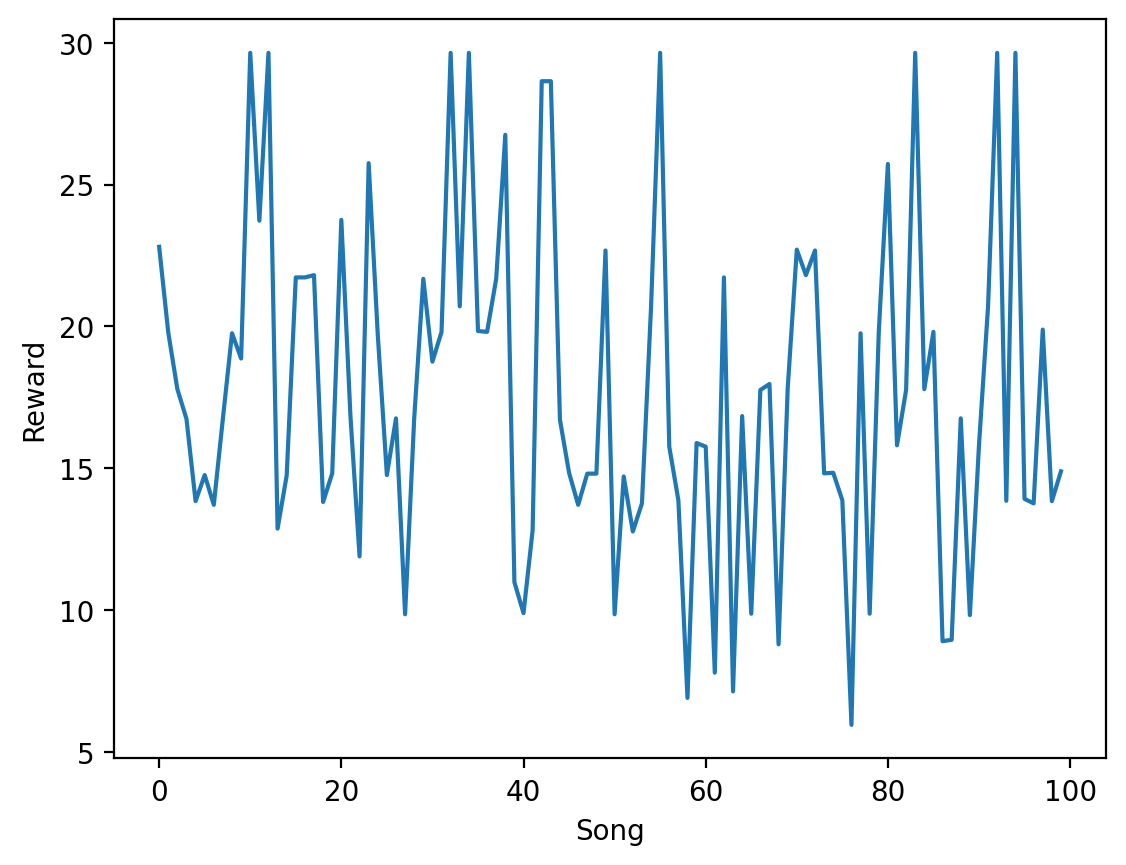

In [61]:
import matplotlib.pyplot as plt
# Calculate the average reward
average_reward = np.mean(song_rewards)
print(f"Average reward: {average_reward}")

# Plot the rewards for each song
plt.plot(song_rewards)
plt.xlabel('Song')
plt.ylabel('Reward')
plt.show()
